# FNO Baseline & Frequency-Ladder Experiments

Goal:
- Train a Fourier Neural Operator (SimpleFNO) for frequency transfer:
  \[
  u(\omega_{\text{src}}) \longrightarrow u(\omega_{\text{tgt}})
  \]
- Systematically explore how training performance depends on the frequencies,
  especially for powers-of-two:
  \[
  (2 \to 4), (4 \to 8), (8 \to 16), (16 \to 32), (16 \to 64), \dots
  \]

Why start with low frequencies?

- At low ω the fields are smoother (few wavelengths on the domain).
- This makes the mapping easier and removes “numerical noise” from the picture.
- Once the setup behaves well for 2→4, 4→8, 8→16, we can:
  - Fix the architecture & hyperparameters
  - Measure how the same FNO behaves for higher pairs, e.g. 16→32, 16→64.

Plan in this notebook:

1. Set up FNO training for a **single (ω_src, ω_tgt)** pair (for detailed tuning).
2. Provide helpers to quickly sweep over a **list of frequency pairs**.
3. Use the same code for:
   - Low-frequency debugging (2→4, 4→8, 8→16)
   - Higher-frequency experiments (e.g. 16→64).


In [1]:
import sys
from pathlib import Path

import numpy as np
import torch
from torch import manual_seed
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# Detect project root (directory containing src/)
# -------------------------------------------------------------------
CWD = Path.cwd()
PROJECT_ROOT = None

for parent in [CWD, *CWD.parents]:
    if (parent / "src" / "__init__.py").exists():
        PROJECT_ROOT = parent
        break

if PROJECT_ROOT is None:
    raise RuntimeError(f"Could not find project root containing src/. Started search from {CWD}")

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("PROJECT_ROOT =", PROJECT_ROOT)

# Device & seeds
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

np.random.seed(0)
manual_seed(0)


PROJECT_ROOT = c:\Users\31624\Documents\MIT\Programming\FreqTransfer
Using device: cpu


In [2]:
from src.config import GridSpec, PMLConfig
from src.data import (
    get_freq_dataset,
    CoordWrapper,
    OmegaChannelWrapper,
)
from src.ml import (
    SimpleFNO,
    train_model,
    eval_relative_metrics,
)


In [3]:
# -------------------------------------------------------------------
# Numerical grid & PML configuration
# -------------------------------------------------------------------
grid = GridSpec(
    dims=2,
    shape=(48, 48),
    lengths=(1.0, 1.0),
)
pml_cfg = PMLConfig(
    thickness=16,
    m=2,
    sigma_max=10.0,
)

def omega_to_k(omega: float) -> float:
    # c = 1
    return omega

# -------------------------------------------------------------------
# FNO hyperparameters (can be tuned later)
# -------------------------------------------------------------------
N_samples = 512      # dataset size per (ω_src, ω_tgt) pair
epochs = 50         # default; you can increase/decrease per experiment
batch_size = 16
lr = 1e-3
val_split = 0.2

fno_width = 64
fno_modes = (12, 12)
fno_layers = 4

print("Grid:", grid)
print("PML:", pml_cfg)
print("FNO width:", fno_width, "modes:", fno_modes, "layers:", fno_layers)


Grid: GridSpec(dims=2, shape=(48, 48), lengths=(1.0, 1.0))
PML: PMLConfig(thickness=16, m=2, sigma_max=10.0)
FNO width: 64 modes: (12, 12) layers: 4


## Helper functions

We define:

- `build_freq_dataset(omega_src, omega_tgt)`  
  → builds the frequency-transfer dataset with:
    - input: `[Re(u_src), Im(u_src), ω_channel, x, y]`
    - target: `[Re(u_tgt), Im(u_tgt)]`

- `build_fno_model(in_ch)`  
  → constructs a `SimpleFNO` with the chosen width/modes/layers.

- `train_fno_for_pair(omega_src, omega_tgt, ..., warm_start_model=None)`  
  → trains FNO for one frequency pair, returns `(model, hist, metrics)`.

`warm_start_model` lets you do curriculum:
- e.g. first train on 4→8, then fine-tune the *same* model on 8→16 or 16→32.


In [4]:
from torch.utils.data import Dataset

def build_freq_dataset(
    omega_src: float,
    omega_tgt: float,
    N_samples: int = N_samples,
) -> Dataset:
    """
    Build (or load cached) dataset for a given frequency pair.
    Input channels: [Re(u_src), Im(u_src), ω_channel, x, y]
    Target:         [Re(u_tgt), Im(u_tgt)]
    """
    print(f"\n=== Building dataset for ω_src={omega_src}, ω_tgt={omega_tgt}, N={N_samples} ===")
    freq_ds_raw = get_freq_dataset(
        grid=grid,
        pml=pml_cfg,
        omega_src=omega_src,
        omega_tgt=omega_tgt,
        N_samples=N_samples,
        omega_to_k=omega_to_k,
        overwrite=False,
    )

    # Add ω channel + spatial coordinates
    freq_ds = OmegaChannelWrapper(freq_ds_raw, omega_src=omega_src, omega_tgt=omega_tgt)
    freq_ds = CoordWrapper(freq_ds, grid=grid, normalise=True)

    x0, y0 = freq_ds[0]
    print("Input shape :", x0.shape)  # (C_in, H, W)
    print("Target shape:", y0.shape)  # (2, H, W)
    return freq_ds


def build_fno_model(in_ch: int) -> SimpleFNO:
    """Construct a SimpleFNO model with current global hyperparameters."""
    model = SimpleFNO(
        in_ch=in_ch,
        width=fno_width,
        modes=fno_modes,
        layers=fno_layers,
        out_ch=2,
        use_global_skip=False,
    ).to(device)
    return model


def train_fno_for_pair(
    omega_src: float,
    omega_tgt: float,
    N_samples: int = N_samples,
    epochs: int = epochs,
    batch_size: int = batch_size,
    lr: float = lr,
    val_split: float = val_split,
    warm_start_model: SimpleFNO | None = None,
):
    """
    Train (or fine-tune) an FNO for a single frequency pair.
    Returns:
        model, hist, metrics
    """
    # 1) Dataset
    freq_ds = build_freq_dataset(omega_src, omega_tgt, N_samples=N_samples)
    x0, y0 = freq_ds[0]
    in_ch = x0.shape[0]

    # 2) Model
    if warm_start_model is None:
        model = build_fno_model(in_ch)
    else:
        model = warm_start_model.to(device)
        if in_ch != model.in_ch:
            raise ValueError(f"warm_start_model expects in_ch={model.in_ch}, got {in_ch}")

    # 3) Train
    print(f"\n=== Training FNO for ω_src={omega_src} → ω_tgt={omega_tgt} ===")
    model, hist = train_model(
        model=model,
        dataset=freq_ds,
        epochs=epochs,
        batch_size=batch_size,
        lr=lr,
        val_split=val_split,
        loss_type="mse",   # start with MSE; you can also try "rel_l2"
        device=device,
        verbose=True,
    )

    # 4) Evaluate
    metrics = eval_relative_metrics(
        model,
        freq_ds,
        batch_size=batch_size,
        device=device,
    )
    print("\nMetrics:", metrics)

    return model, hist, metrics, freq_ds


## Single-pair FNO training (for fine-tuning hyperparameters)

Start with a modest low-frequency pair, e.g. **4 → 8**, to:

- Debug architecture and training behaviour.
- Get a sense of reasonable metrics (rel L2, mag/phase RMSE).
- Tune `width`, `modes`, `layers`, `epochs`.

Once you’re happy with these settings, reuse them for the ladder sweep.


In [8]:
# Choose a single frequency pair for detailed tuning
omega_src_single = 4.0
omega_tgt_single = 8.0

single_model, single_hist, single_metrics, single_ds = train_fno_for_pair(
    omega_src=omega_src_single,
    omega_tgt=omega_tgt_single,
    N_samples=N_samples,
    epochs=epochs,
    batch_size=batch_size,
    lr=lr,
    val_split=val_split,
    warm_start_model=None,   # or pass a previous model for fine-tuning
)

print("\n=== Final metrics for single pair ===")
for k, v in single_metrics.items():
    print(f"{k:>15s}: {v:.4e}")



=== Building dataset for ω_src=4.0, ω_tgt=8.0, N=512 ===
[get_freq_dataset] Loading cached dataset from: C:\Users\31624\Documents\MIT\Programming\FreqTransfer\data\freq_transfer_cached\wsrc4p000_wtgt8p000_N512_grid48x48_pmlT16_m2_sig10p00
  Loaded N=512 samples, ω_src=4.0, ω_tgt=8.0
Input shape : torch.Size([6, 48, 48])
Target shape: torch.Size([2, 48, 48])

=== Training FNO for ω_src=4.0 → ω_tgt=8.0 ===
[001/50] train=4.8000e-04  val=1.8388e-05
[002/50] train=8.7280e-06  val=2.3721e-06
[003/50] train=6.5217e-07  val=1.4462e-08
[004/50] train=5.6147e-08  val=2.7411e-08
[005/50] train=1.4439e-08  val=1.2314e-08
[006/50] train=1.1110e-08  val=1.1021e-08
[007/50] train=1.0688e-08  val=1.0827e-08
[008/50] train=1.0496e-08  val=1.0603e-08
[009/50] train=1.0289e-08  val=1.0429e-08
[010/50] train=1.0092e-08  val=1.0218e-08
[011/50] train=9.8931e-09  val=9.9717e-09
[012/50] train=9.6960e-09  val=9.8343e-09
[013/50] train=9.4901e-09  val=9.5891e-09
[014/50] train=9.2918e-09  val=9.3799e-09
[01

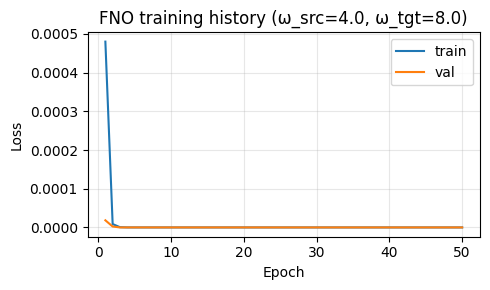

In [9]:
train_loss = single_hist["train"]
val_loss = single_hist["val"]
epochs_range = np.arange(1, len(train_loss) + 1)

plt.figure(figsize=(5, 3))
plt.plot(epochs_range, train_loss, label="train")
plt.plot(epochs_range, val_loss, label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"FNO training history (ω_src={omega_src_single}, ω_tgt={omega_tgt_single})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


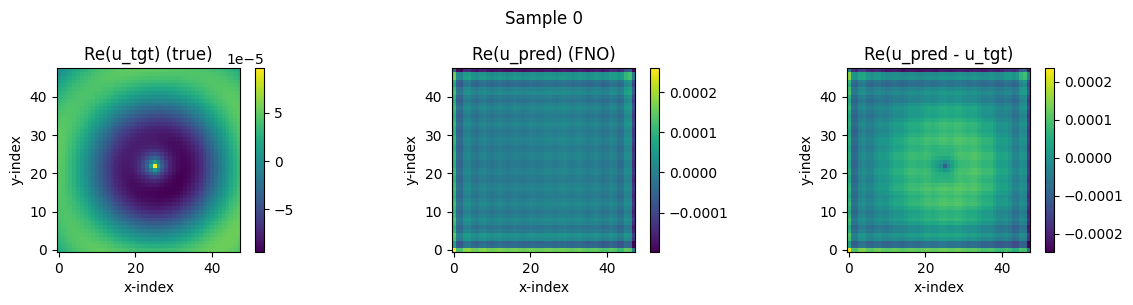

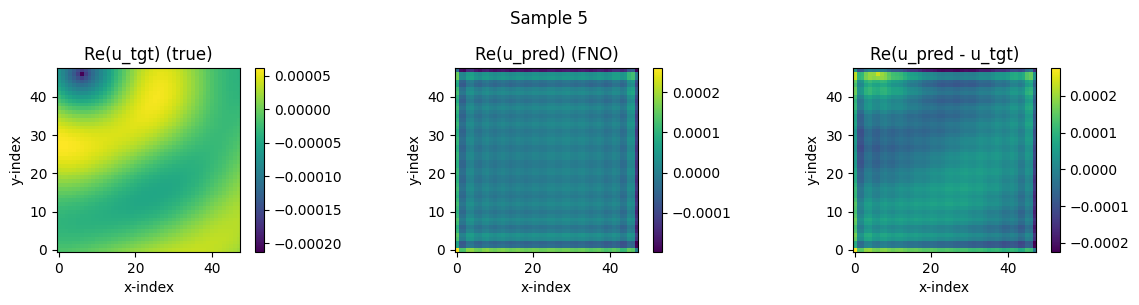

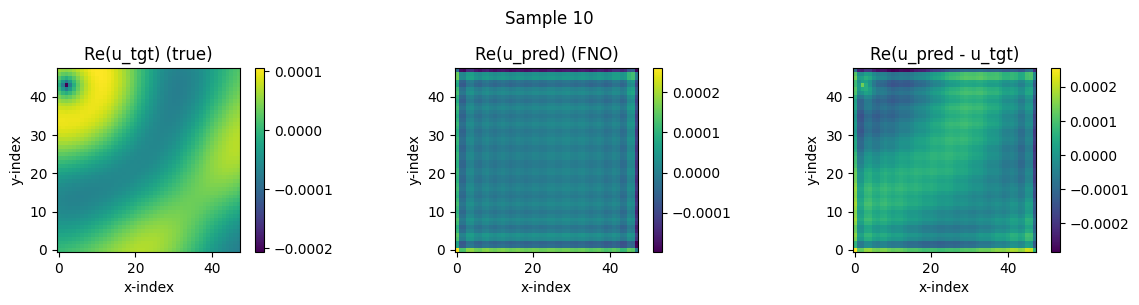

In [10]:
def plot_fno_prediction_example(model, dataset, idx: int = 0, device: str = "cpu"):
    model = model.to(device).eval()
    with torch.no_grad():
        x, y = dataset[idx]
        x = x.unsqueeze(0).to(device)
        y = y.unsqueeze(0).to(device)
        yhat = model(x)

    y_np = y[0].cpu().numpy()
    yh_np = yhat[0].cpu().numpy()

    tgt_real = y_np[0]
    pred_real = yh_np[0]
    diff_real = pred_real - tgt_real

    fig, axes = plt.subplots(1, 3, figsize=(12, 3))

    im0 = axes[0].imshow(tgt_real, origin="lower")
    axes[0].set_title("Re(u_tgt) (true)")
    plt.colorbar(im0, ax=axes[0])

    im1 = axes[1].imshow(pred_real, origin="lower")
    axes[1].set_title("Re(u_pred) (FNO)")
    plt.colorbar(im1, ax=axes[1])

    im2 = axes[2].imshow(diff_real, origin="lower")
    axes[2].set_title("Re(u_pred - u_tgt)")
    plt.colorbar(im2, ax=axes[2])

    for ax in axes:
        ax.set_xlabel("x-index")
        ax.set_ylabel("y-index")
    fig.suptitle(f"Sample {idx}")
    fig.tight_layout()
    plt.show()

# Inspect a few samples
for idx in [0, 5, 10]:
    plot_fno_prediction_example(single_model, single_ds, idx=idx, device=device)


## DEBUGGING

In [12]:
x, y = single_ds[0]
print("target y mean:", y.mean().item())
print("target y std:", y.std().item())
print("target y max:", y.max().item(), "min:", y.min().item())


target y mean: -1.4315812222776003e-05
target y std: 4.7514582547592e-05
target y max: 0.0003425756876822561 min: -9.424838935956359e-05


In [ ]:
from src.data import ScaleWrapper
freq_ds_raw = get_freq_dataset(...)
freq_ds = ScaleWrapper(freq_ds_raw, factor=1e4)
freq_ds = OmegaChannelWrapper(...)
freq_ds = CoordWrapper(...)


In [13]:
with torch.no_grad():
    pred = single_model(x.unsqueeze(0).to(device))
print("Prediction mean amplitude:", pred.abs().mean().item())


Prediction mean amplitude: 2.7515479814610444e-05


## END DEBUGGING

In [14]:
# -------------------------------------------------------------------
# Updated FNO hyperparameters (more capacity)
# -------------------------------------------------------------------
N_samples = 512      # dataset size per (ω_src, ω_tgt) pair
epochs = 50         # you can later bump this if needed
batch_size = 16
lr = 1e-3
val_split = 0.2

# ⬆️ Capacity boost: wider, deeper, more modes
fno_width = 96          # was 64
fno_modes = (16, 16)    # was (12, 12)
fno_layers = 6          # was 4

print("Updated FNO hyperparameters:")
print("  width :", fno_width)
print("  modes :", fno_modes)
print("  layers:", fno_layers)


Updated FNO hyperparameters:
  width : 96
  modes : (16, 16)
  layers: 6


In [15]:
def train_fno_for_pair(
    omega_src: float,
    omega_tgt: float,
    N_samples: int = N_samples,
    epochs: int = epochs,
    batch_size: int = batch_size,
    lr: float = lr,
    val_split: float = val_split,
    warm_start_model: SimpleFNO | None = None,
    loss_type: str = "rel_l2",   # <-- default to relative L2
):
    """
    Train (or fine-tune) an FNO for a single frequency pair.
    Uses loss_type (default: 'rel_l2').

    Returns:
        model, hist, metrics, dataset
    """
    # 1) Dataset
    freq_ds = build_freq_dataset(omega_src, omega_tgt, N_samples=N_samples)
    x0, y0 = freq_ds[0]
    in_ch = x0.shape[0]

    # 2) Model
    if warm_start_model is None:
        model = build_fno_model(in_ch)
    else:
        model = warm_start_model.to(device)
        if in_ch != model.in_ch:
            raise ValueError(f"warm_start_model expects in_ch={model.in_ch}, got {in_ch}")

    # 3) Train
    print(f"\n=== Training FNO for ω_src={omega_src} → ω_tgt={omega_tgt} "
          f"(loss={loss_type}) ===")
    model, hist = train_model(
        model=model,
        dataset=freq_ds,
        epochs=epochs,
        batch_size=batch_size,
        lr=lr,
        val_split=val_split,
        loss_type=loss_type,   # <-- now configurable
        device=device,
        verbose=True,
    )

    # 4) Evaluate
    metrics = eval_relative_metrics(
        model,
        freq_ds,
        batch_size=batch_size,
        device=device,
    )
    print("\nMetrics:", metrics)

    return model, hist, metrics, freq_ds


In [16]:
omega_src_single = 4.0
omega_tgt_single = 8.0

single_model, single_hist, single_metrics, single_ds = train_fno_for_pair(
    omega_src=omega_src_single,
    omega_tgt=omega_tgt_single,
    N_samples=N_samples,
    epochs=epochs,
    batch_size=batch_size,
    lr=lr,
    val_split=val_split,
    warm_start_model=None,
    loss_type="rel_l2",   # explicit, though default
)

print("\n=== Final metrics for single pair (4 → 8, FNO, rel_L2) ===")
for k, v in single_metrics.items():
    print(f"{k:>15s}: {v:.4e}")



=== Building dataset for ω_src=4.0, ω_tgt=8.0, N=512 ===
[get_freq_dataset] Loading cached dataset from: C:\Users\31624\Documents\MIT\Programming\FreqTransfer\data\freq_transfer_cached\wsrc4p000_wtgt8p000_N512_grid48x48_pmlT16_m2_sig10p00
  Loaded N=512 samples, ω_src=4.0, ω_tgt=8.0
Input shape : torch.Size([6, 48, 48])
Target shape: torch.Size([2, 48, 48])

=== Training FNO for ω_src=4.0 → ω_tgt=8.0 (loss=rel_l2) ===
[001/50] train=1.4474e+02  val=5.9447e+01
[002/50] train=4.1779e+01  val=1.1719e+01
[003/50] train=2.8551e+01  val=3.1468e+01
[004/50] train=2.6050e+01  val=5.2109e+01
[005/50] train=2.8302e+01  val=1.2110e+01
[006/50] train=3.3531e+01  val=4.9247e+01
[007/50] train=4.3604e+01  val=2.4157e+01
[008/50] train=2.6603e+01  val=3.6844e+01
[009/50] train=2.8397e+01  val=5.4382e+01
[010/50] train=4.9298e+01  val=2.6994e+01
[011/50] train=1.8731e+01  val=2.4525e+01
[012/50] train=3.2644e+01  val=3.3975e+01
[013/50] train=2.4262e+01  val=7.5645e+00
[014/50] train=1.9560e+01  val=

In [17]:
sweep_epochs = 30  # or 50 if you can afford it

sweep_results = []
for (omega_src, omega_tgt) in freq_pairs:
    print("\n" + "=" * 80)
    print(f"FNO Frequency Transfer: ω_src={omega_src} → ω_tgt={omega_tgt}")
    print("=" * 80)

    model_ft, hist_ft, metrics_ft, _ = train_fno_for_pair(
        omega_src=omega_src,
        omega_tgt=omega_tgt,
        N_samples=N_samples,
        epochs=sweep_epochs,
        batch_size=batch_size,
        lr=lr,
        val_split=val_split,
        warm_start_model=None,
        loss_type="rel_l2",   # <-- key change
    )

    sweep_results.append({
        "omega_src": omega_src,
        "omega_tgt": omega_tgt,
        **metrics_ft,
    })



FNO Frequency Transfer: ω_src=2.0 → ω_tgt=4.0

=== Building dataset for ω_src=2.0, ω_tgt=4.0, N=512 ===
[get_freq_dataset] Generating new dataset: wsrc2p000_wtgt4p000_N512_grid48x48_pmlT16_m2_sig10p00
  solving sample 0/512 ...
  solving sample 51/512 ...
  solving sample 102/512 ...
  solving sample 153/512 ...
  solving sample 204/512 ...
  solving sample 255/512 ...
  solving sample 306/512 ...
  solving sample 357/512 ...
  solving sample 408/512 ...
  solving sample 459/512 ...
  solving sample 510/512 ...
[get_freq_dataset] Saved dataset to C:\Users\31624\Documents\MIT\Programming\FreqTransfer\data\freq_transfer_cached\wsrc2p000_wtgt4p000_N512_grid48x48_pmlT16_m2_sig10p00
  X.npy shape: (512, 2, 48, 48)
  Y.npy shape: (512, 2, 48, 48)
Input shape : torch.Size([6, 48, 48])
Target shape: torch.Size([2, 48, 48])

=== Training FNO for ω_src=2.0 → ω_tgt=4.0 (loss=rel_l2) ===
[001/30] train=9.7300e+01  val=1.6685e+01
[002/30] train=1.2679e+01  val=9.4812e+00
[003/30] train=1.2301e+01 

## IMPROVED FNO

## END IMPROVED FNO

## Frequency-ladder sweep

Now we define a list of frequency pairs, e.g.:

- Low frequencies: (2 → 4), (4 → 8), (8 → 16)
- Higher: (16 → 32), (16 → 64)

For each pair we:

- Build a dataset
- Train a (fresh) FNO for fewer epochs (to keep it affordable)
- Record final metrics

This gives a **curve of difficulty vs frequency level / ratio**.
You can then decide where to invest more epochs or try curriculum
(pretraining on low ω, fine-tuning on high ω).


In [11]:
# Define the ladder of frequency pairs you want to test
freq_pairs = [
    (2.0, 4.0),
    (4.0, 8.0),
    (8.0, 16.0),
    (16.0, 32.0),
    # You can uncomment / add:
    # (16.0, 64.0),
]

# For the sweep, you might reduce epochs to keep runtimes manageable
sweep_epochs = 30

sweep_results = []

for (omega_src, omega_tgt) in freq_pairs:
    print("\n" + "=" * 80)
    print(f"FNO Frequency Transfer: ω_src={omega_src} → ω_tgt={omega_tgt}")
    print("=" * 80)

    model_ft, hist_ft, metrics_ft, _ = train_fno_for_pair(
        omega_src=omega_src,
        omega_tgt=omega_tgt,
        N_samples=N_samples,
        epochs=sweep_epochs,
        batch_size=batch_size,
        lr=lr,
        val_split=val_split,
        warm_start_model=None,   # for curriculum, pass previous model here
    )

    sweep_results.append({
        "omega_src": omega_src,
        "omega_tgt": omega_tgt,
        **metrics_ft,
    })

print("\n=== Sweep results ===")
for res in sweep_results:
    print(
        f"ω_src={res['omega_src']:>4.1f}, ω_tgt={res['omega_tgt']:>4.1f} | "
        f"rel_L2_mean={res['rel_L2_mean']:.3e}, "
        f"mag_RMSE={res['mag_RMSE']:.3e}, "
        f"phase_RMSE={res['phase_RMSE']:.3e}"
    )



FNO Frequency Transfer: ω_src=2.0 → ω_tgt=4.0

=== Building dataset for ω_src=2.0, ω_tgt=4.0, N=512 ===
[get_freq_dataset] Generating new dataset: wsrc2p000_wtgt4p000_N512_grid48x48_pmlT16_m2_sig10p00
  solving sample 0/512 ...
  solving sample 51/512 ...
  solving sample 102/512 ...
  solving sample 153/512 ...
  solving sample 204/512 ...
  solving sample 255/512 ...
  solving sample 306/512 ...
  solving sample 357/512 ...
  solving sample 408/512 ...
  solving sample 459/512 ...


KeyboardInterrupt: 

In [ ]:
# Visualise how performance changes along the ladder
targets = [res["omega_tgt"] for res in sweep_results]
relL2 = [res["rel_L2_mean"] for res in sweep_results]

plt.figure(figsize=(5, 3))
plt.plot(targets, relL2, marker="o")
plt.xlabel(r"$\omega_{\text{tgt}}$")
plt.ylabel("rel_L2_mean")
plt.title("FNO performance vs target frequency")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
